In [ ]:
import pandas as pd
import glob
import numpy as np
import re
import os

xlsx_path = "C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//0list.xlsx"
scores_df = pd.read_excel(xlsx_path)

score_map = {
    int(row["Patient"]): float(row["Score (type)"])
    for _, row in scores_df.iterrows()
}

def load_clean_csv(path):
    df = pd.read_csv(path)
    df = df.dropna(axis=1, how="all")
    return df

folder = "C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//Resultados"

files = glob.glob(os.path.join(folder, "*.csv"))

healthy_files = {}
patho_files = {}

pattern = r"Elastome_(\d+)_(Healthy|Patho)_angle_(\d+)\.csv"

for f in files:
    name = os.path.basename(f)
    m = re.match(pattern, name)
    if not m:
        continue
    num = m.group(1)
    kind = m.group(2)
    angle = m.group(3)
    key = (num, angle)
    if kind.lower() == "healthy":
        healthy_files[key] = f
    elif kind.lower() == "patho":
        patho_files[key] = f

samples = []

for key in sorted(healthy_files.keys()):
    if key not in patho_files:
        continue

    num_str, angle = key
    patient_id = int(num_str)

    if patient_id not in score_map:
        continue

    y = score_map[patient_id]

    df_h = load_clean_csv(healthy_files[key])
    df_p = load_clean_csv(patho_files[key])

    healthy_signals = [df_h[col].values for col in df_h.columns]
    L = min(len(healthy_signals[0]), len(df_p))

    healthy_signals = [s[:L] for s in healthy_signals]

    for pcol in df_p.columns:

        patho_signal = df_p[pcol].values[:L]
        all_signals = [patho_signal] + healthy_signals
        X = np.stack(all_signals, axis=0)

        # ----------- META DATA -----------
        meta = {
            "patient_id": patient_id,
            "angle": angle,
            "score_y": y,
            "patho_file": patho_files[key],
            "healthy_file": healthy_files[key],
            "patho_col": pcol,
            "healthy_cols": list(df_h.columns),
            "num_healthy_cols": len(df_h.columns),
            "signal_length": L,
            "X_shape": X.shape,
            "patho_signal_shape": patho_signal.shape,
        }
        # --------------------------------------

        samples.append(
            {
                "elastome": num_str,
                "angle": angle,
                "patho_col": pcol,
                "X": X,
                "y": y,
                "meta": meta,
            }
        )

print("Nombre total d'échantillons :", len(samples))
print("Shape du premier X :", samples[0]["X"].shape)
print("Label du premier échantillon :", samples[0]["y"])


Nombre total d'échantillons : 140
Shape du premier X : (8, 2000)
Label du premier échantillon : 3.0


In [18]:
i = 0
s = samples[i]

print("=== SAMPLE", i, "===")
print("X shape:", s["X"].shape)
print("y:", s["y"])

print("\nMeta data :")
for k, v in s["meta"].items():
    print(f"- {k}: {v}")


=== SAMPLE 0 ===
X shape: (8, 2000)
y: 3.0

Meta data :
- patient_id: 1
- angle: 1
- score_y: 3.0
- patho_file: C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//Resultados\Elastome_0001_Patho_angle_1.csv
- healthy_file: C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//Resultados\Elastome_0001_Healthy_angle_1.csv
- patho_col: F3_1000Hz
- healthy_cols: ['F3_1000Hz', 'F4_900Hz', 'F5_800Hz', 'F6_700Hz', 'F7_600Hz', 'F8_500Hz', 'F9_400Hz']
- num_healthy_cols: 7
- signal_length: 2000
- X_shape: (8, 2000)
- patho_signal_shape: (2000,)


The idea here is to create the vectors "images". We will first import and then pack by 5 the signals. first : Patho, four following : reference from Healthy.

In [ ]:
import pandas as pd
import glob
import numpy as np
import re
import os

xlsx_path = "C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//0list.xlsx"
scores_df = pd.read_excel(xlsx_path)

score_map = {
    int(row["Patient"]): float(row["Score (type)"])
    for _, row in scores_df.iterrows()
}

def load_clean_csv(path):
    df = pd.read_csv(path)
    df = df.dropna(axis=1, how="all")
    return df

folder = "C://Users//crampterMaxx//Documents//5A//SP//Elastography + AI//Skin//Resultados"

files = glob.glob(os.path.join(folder, "*.csv"))

healthy_files = {}
patho_files = {}

pattern = r"Elastome_(\d+)_(Healthy|Patho)_angle_(\d+)\.csv"

for f in files:
    name = os.path.basename(f)
    m = re.match(pattern, name)
    if not m:
        continue
    num = m.group(1)
    kind = m.group(2)
    angle = m.group(3)
    key = (num, angle)
    if kind.lower() == "healthy":
        healthy_files[key] = f
    elif kind.lower() == "patho":
        patho_files[key] = f

samples = []

for key in sorted(healthy_files.keys()):
    if key not in patho_files:
        continue

    num_str, angle = key
    patient_id = int(num_str)

    if patient_id not in score_map:
        continue

    y = score_map[patient_id]

    df_h = load_clean_csv(healthy_files[key])
    df_p = load_clean_csv(patho_files[key])

    healthy_signals = [df_h[col].values for col in df_h.columns]
    L = min(len(healthy_signals[0]), len(df_p))

    healthy_signals = [s[:L] for s in healthy_signals]

    for pcol in df_p.columns:
        patho_signal = df_p[pcol].values[:L]
        all_signals = [patho_signal] + healthy_signals
        X = np.stack(all_signals, axis=0)
        samples.append(
            {
                "elastome": num_str,
                "angle": angle,
                "patho_col": pcol,
                "X": X,
                "y": y,
            }
        )

print("Nombre total d'échantillons :", len(samples))
print("Shape du premier X :", samples[0]["X"].shape)
print("Label du premier échantillon :", samples[0]["y"])
print("")


Nombre total d'échantillons : 140
Shape du premier X : (8, 2000)
Label du premier échantillon : [[-2.29581736e-03 -3.77555854e-03 -3.69376979e-03 ... -2.75922484e-03
  -2.34301678e-03 -2.75378592e-03]
 [-2.25134101e-03 -2.82958057e-03 -3.23126000e-03 ... -9.22348258e-03
  -8.69650301e-03 -9.00460314e-03]
 [-2.75177794e-03 -2.18640926e-03 -1.79180789e-03 ... -1.17064631e-02
  -1.14846407e-02 -1.13507538e-02]
 ...
 [-1.46809647e-03 -1.86280961e-03 -1.05753223e-03 ... -1.46439826e-02
  -1.48764221e-02 -1.36945737e-02]
 [ 2.55204485e-04  1.12165969e-05 -1.86596318e-04 ... -1.13805535e-02
  -1.03813003e-02 -1.03458355e-02]
 [ 1.43637367e-03  1.33636826e-03  7.22496295e-04 ... -1.07782013e-02
  -1.07428855e-02 -1.02827191e-02]]


In [14]:
i = 3 # index of the sample you want to inspect

sample = samples[i]

print("=== SAMPLE ===")
for k, v in sample.items():
    if isinstance(v, np.ndarray):
        print(f"{k} : ndarray shape={v.shape}")
    else:
        print(f"{k} : {v}")

=== SAMPLE ===
elastome : 0001
angle : 1
patho_col : F6_700Hz
X : ndarray shape=(8, 2000)
y : 3.0


In [16]:
print(sample.keys())


dict_keys(['elastome', 'angle', 'patho_col', 'X', 'y'])


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset

for s in samples:
    y = s["y"]
    y_class = int(np.clip(np.rint(y), 0, 5))
    s["y_class"] = y_class

class ElastomeClassifDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X = self.samples[idx]["X"]
        y = self.samples[idx]["y_class"]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return X, y

dataset = ElastomeClassifDataset(samples)

X0, y0 = dataset[0]
print(X0.shape, y0)


torch.Size([8, 2000]) tensor(3)


In [3]:
import torch.nn as nn

class CNN1DClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=6):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x

in_channels = samples[0]["X"].shape[0]
model = CNN1DClassifier(in_channels=in_channels, num_classes=6)
print(model)


CNN1DClassifier(
  (conv1): Sequential(
    (0): Conv1d(8, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=Tr

In [4]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels_all = np.array([s["y_class"] for s in samples])
indices = np.arange(len(samples))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_true = []
all_pred = []
all_proba = []
train_acc_per_fold = []
val_acc_per_fold = []

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels_all), 1):
    print(f"\n===== Fold {fold} =====")

    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

    model = CNN1DClassifier(in_channels=in_channels, num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()  # tu peux mettre des class_weights ici si besoin
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    epochs = 25

    for epoch in range(epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            correct_train += (preds == yb).sum().item()
            total_train += yb.size(0)

        train_acc = correct_train / total_train

    # --- validation sur ce fold ---
    model.eval()
    fold_true = []
    fold_pred = []
    fold_proba = []
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            prob = torch.softmax(out, dim=1)
            pred = out.argmax(dim=1)

            correct_val += (pred == yb).sum().item()
            total_val += yb.size(0)

            fold_true.extend(yb.cpu().numpy())
            fold_pred.extend(pred.cpu().numpy())
            fold_proba.extend(prob.cpu().numpy())

    val_acc = correct_val / total_val

    train_acc_per_fold.append(train_acc)
    val_acc_per_fold.append(val_acc)

    print(f"Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")

    all_true.extend(fold_true)
    all_pred.extend(fold_pred)
    all_proba.extend(fold_proba)

all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_proba = np.array(all_proba)

print("\nTrain acc par fold :", train_acc_per_fold)
print("Val acc par fold   :", val_acc_per_fold)
print(f"Train mean={np.mean(train_acc_per_fold):.3f}, Val mean={np.mean(val_acc_per_fold):.3f}")


===== Fold 1 =====
Train acc: 0.893 | Val acc: 0.893

===== Fold 2 =====
Train acc: 0.955 | Val acc: 0.929

===== Fold 3 =====
Train acc: 0.920 | Val acc: 0.893

===== Fold 4 =====
Train acc: 0.982 | Val acc: 0.857

===== Fold 5 =====
Train acc: 0.902 | Val acc: 0.964

Train acc par fold : [0.8928571428571429, 0.9553571428571429, 0.9196428571428571, 0.9821428571428571, 0.9017857142857143]
Val acc par fold   : [0.8928571428571429, 0.9285714285714286, 0.8928571428571429, 0.8571428571428571, 0.9642857142857143]
Train mean=0.930, Val mean=0.907


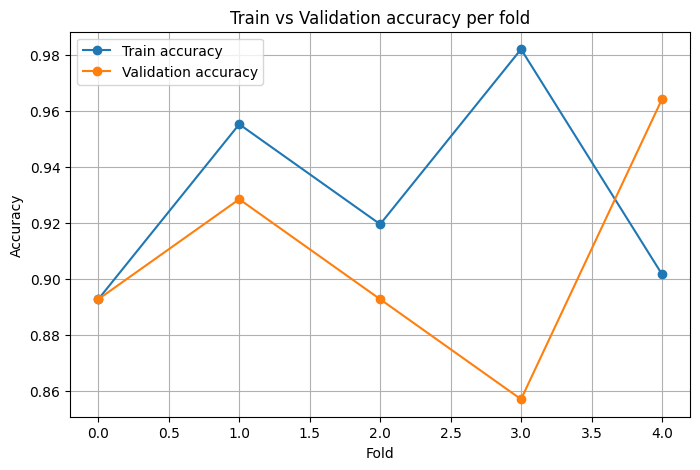

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_acc_per_fold, marker='o', label="Train accuracy")
plt.plot(val_acc_per_fold, marker='o', label="Validation accuracy")

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Train vs Validation accuracy per fold")
plt.legend()
plt.grid(True)
plt.show()


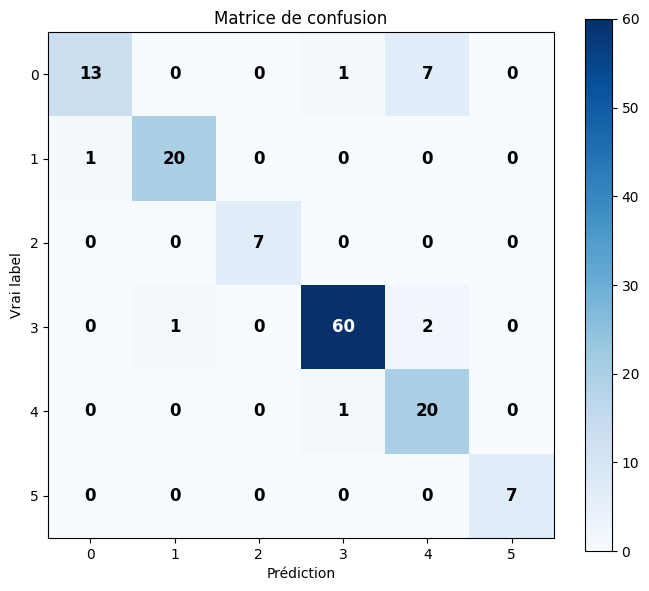

In [6]:
import matplotlib.pyplot as plt
import numpy as np

labels = [0, 1, 2, 3, 4, 5]
auc_macro = roc_auc_score(all_true, all_proba, multi_class="ovr", average="macro")
cm = confusion_matrix(all_true, all_pred, labels=[0, 1, 2, 3, 4, 5])


plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Matrice de confusion")
plt.colorbar()

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Prédiction")
plt.ylabel("Vrai label")

thresh = cm.max() / 2.0

# Écrire les valeurs dans chaque case
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=12, fontweight="bold"
        )

plt.tight_layout()
plt.show()


AUC macro (OVR) : 0.982528364881306


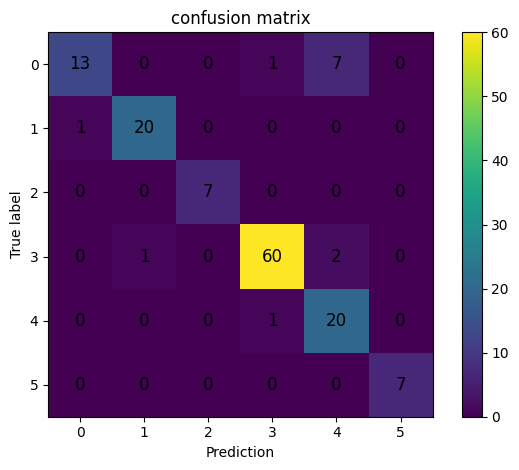

In [7]:
auc_macro = roc_auc_score(all_true, all_proba, multi_class="ovr", average="macro")
print("AUC macro (OVR) :", auc_macro)


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="black",
            fontsize=12,
        )

ax.set(
    xticks=range(6),
    yticks=range(6),
    xticklabels=[0, 1, 2, 3, 4, 5],
    yticklabels=[0, 1, 2, 3, 4, 5],
    xlabel="Prediction",
    ylabel="True label",
    title="confusion matrix"
)
plt.tight_layout()
plt.show()

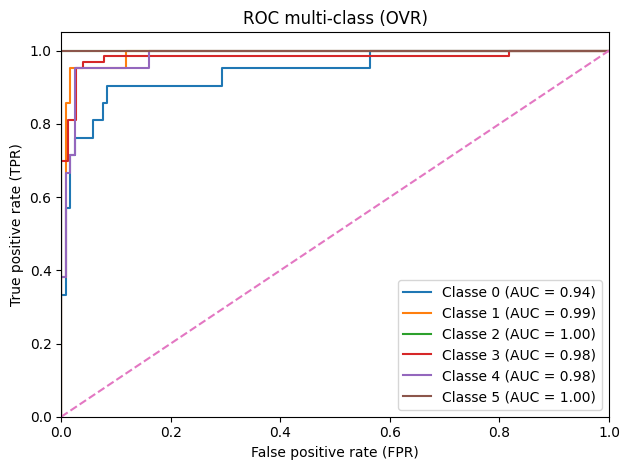

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

n_classes = 6
y_true = all_true
y_score = all_proba

y_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for c in range(n_classes):
    fpr[c], tpr[c], _ = roc_curve(y_bin[:, c], y_score[:, c])
    roc_auc[c] = roc_auc_score(y_bin[:, c], y_score[:, c])

plt.figure()
for c in range(n_classes):
    plt.plot(
        fpr[c],
        tpr[c],
        label=f"Classe {c} (AUC = {roc_auc[c]:.2f})",
    )

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.title("ROC multi-class (OVR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
